<a href="https://colab.research.google.com/github/Crist1am/DataScience_CH/blob/main/Desafio_APIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias necesarias

In [ ]:
#importamos librerias necesarias
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import json_normalize
import plotly.express as px

# Base de los pokemones principales

In [ ]:
#Creamos listas vacias
names = []
weights = []
heights = []
stats = []

#Ciclo for para obtener datos los primeros 9 pokemones
for i in range(1,10):
  url = f"https://pokeapi.co/api/v2/pokemon/{i}"

  response = requests.get(url)
  data = response.json()

  # Extraer información del Pokémon Pikachu
  name = data["name"]
  weight = data["weight"]
  height = data["height"]
  stat = {stat["stat"]["name"]: stat["base_stat"] for stat in data["stats"]}

  #Lo almacenamos en las listas vacias
  names.append(name)
  weights.append(weight)
  heights.append(height)
  stats.append(stat)


In [ ]:
#Creamos el df con los datos guardados
pokemon_data = pd.DataFrame({'Nombre': names, 'Peso': weights, 'Altura': heights, 'Stats': stats})
pokemon_data

,Nombre,Peso,Altura,Stats
0,bulbasaur,69,7,"{'hp': 45, 'attack': 49, 'defense': 49, 'speci..."
1,ivysaur,130,10,"{'hp': 60, 'attack': 62, 'defense': 63, 'speci..."
2,venusaur,1000,20,"{'hp': 80, 'attack': 82, 'defense': 83, 'speci..."
3,charmander,85,6,"{'hp': 39, 'attack': 52, 'defense': 43, 'speci..."
4,charmeleon,190,11,"{'hp': 58, 'attack': 64, 'defense': 58, 'speci..."
5,charizard,905,17,"{'hp': 78, 'attack': 84, 'defense': 78, 'speci..."
6,squirtle,90,5,"{'hp': 44, 'attack': 48, 'defense': 65, 'speci..."
7,wartortle,225,10,"{'hp': 59, 'attack': 63, 'defense': 80, 'speci..."
8,blastoise,855,16,"{'hp': 79, 'attack': 83, 'defense': 100, 'spec..."


Como vemos, en el df creado existe un json anidado (en la columna Stats), por lo que es necesario desanidarlo y generar nuevas columnas.
Para esto usamos el **json_normalize**

In [ ]:
# Normalizamos la columna 'Stats' para descomponer el JSON anidado en columnas separadas
normalized_stats = json_normalize(pokemon_data['Stats'])

# Concatenamos las columnas normalizadas al DataFrame original
pokemon_data = pd.concat([pokemon_data, normalized_stats], axis=1)

# Eliminamos la columna Stats (ya que se descompuso en 6 columnas)
pokemon_data = pokemon_data.drop(columns=['Stats'])

In [ ]:
#Vemos el nuevo df
pokemon_data

,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed
0,bulbasaur,69,7,45,49,49,65,65,45
1,ivysaur,130,10,60,62,63,80,80,60
2,venusaur,1000,20,80,82,83,100,100,80
3,charmander,85,6,39,52,43,60,50,65
4,charmeleon,190,11,58,64,58,80,65,80
5,charizard,905,17,78,84,78,109,85,100
6,squirtle,90,5,44,48,65,50,64,43
7,wartortle,225,10,59,63,80,65,80,58
8,blastoise,855,16,79,83,100,85,105,78


Haremos 3 graficos comparando cada uno de los pokemones principales con sus pares

## Grafico de barra de los pokemones principales

Dado que será repetitivo el procedimiento para graficar cada pokemon, creamos una funcion que nos permita realizar esto más rapido y de mejor manera

In [ ]:
def grafico_pkm (a,b,c):
    pokemon_subset = pokemon_data.loc[pokemon_data.index.isin(indices_pokemon)]
    color_map = {
    pokemon_subset['Nombre'][a]: 'green',
    pokemon_subset['Nombre'][b]: 'red',
    pokemon_subset['Nombre'][c]: 'blue'
    }
    fig = px.bar(pokemon_subset, x='attack', y='defense',color = 'Nombre', color_discrete_map=color_map, title='Gráfico comparativo de pokemones')
    fig.show()

In [ ]:
#Primero creamos un range para que vaya desde los indices del 0 al 2 (es decir, que tome 3 opciones)
for i in range(0,3):
  if i == 0:
    indices_pokemon=[0,3,6]
    grafico_pkm(indices_pokemon[0],indices_pokemon[1], indices_pokemon[2])

  elif i == 1:
    indices_pokemon=[1,4,7]
    grafico_pkm(indices_pokemon[0],indices_pokemon[1], indices_pokemon[2])

  elif i == 2:
    indices_pokemon=[2,5,8]
    grafico_pkm(indices_pokemon[0],indices_pokemon[1], indices_pokemon[2])


De acuerdo a lo que vemos en los 3 gráficos, en la fase inicial de cada pokemon, existe una tendencia de a mayor ataque, menor es la defensa del pokemon, en este caso, charmander es aquel que tiene un mayor ataque pero una menor defensa. Por el otro lado, squirtle es el que tiene un menor ataque pero una mayor defensa.
Para las primeras evoluciones (segundo gráfico), charmeleon (tipo fuego) se mantiene como el que tiene un mayor ataque, sin embargo, el pokemon tipo agua supera al hierba (wartortle supera a ivysaur) en ataque y wartortle se mantiene como aquel con mayor defensa.
Para el ultimo grafico, los 3 pokemones mantienen sus posiciones, es decir, charizar es quien tiene un mayor ataque, blastoise está en segundo lugar y venusaur es quien tiene el menor ataque. En el caso de las defensas, tambien mantienen sus lugares. El punto más relevante está en que, en el caso de ataque, la diferencia entre cada uno es de un punto (84, 83 y 82), por lo que son similares, pero en la defensa, blastoise supera en gran cantidad a sus competidores (100 vs 83 venusaur vs 78 charizard). Se puede concluir que el pokemon tipo agua en terminos de ataque/defensa es el más completo

## Grafico de radar

In [ ]:
#duplicamos el primer df para no tocarlo
pkm_data = pokemon_data

In [ ]:
# Seleccionamos los atributos para el gráfico de radar.
factors = ['Peso', 'Altura', 'hp', 'attack', 'defense', 'special-attack',
       'special-defense', 'speed']

In [ ]:
#normalizamos los datos de esas columnas para que los valores esten entre 0 y 1
for i in factors:
  min = pkm_data[i].min()
  max = pkm_data[i].max()
  pkm_data[i]=(pkm_data[i]-min)/(max-min)

In [ ]:
#transformamos la columna "Nombre" en indice
pkm_data.set_index(pkm_data['Nombre'], inplace=True)
pkm_data

,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed
Nombre,,,,,,,,,
bulbasaur,bulbasaur,0.000000,0.133333,0.146341,0.027778,0.105263,0.254237,0.272727,0.035088
ivysaur,ivysaur,0.065521,0.333333,0.512195,0.388889,0.350877,0.508475,0.545455,0.298246
venusaur,venusaur,1.000000,1.000000,1.000000,0.944444,0.701754,0.847458,0.909091,0.649123
charmander,charmander,0.017186,0.066667,0.000000,0.111111,0.000000,0.169492,0.000000,0.385965
charmeleon,charmeleon,0.129968,0.400000,0.463415,0.444444,0.263158,0.508475,0.272727,0.649123
charizard,charizard,0.897959,0.800000,0.951220,1.000000,0.614035,1.000000,0.636364,1.000000
squirtle,squirtle,0.022556,0.000000,0.121951,0.000000,0.385965,0.000000,0.254545,0.000000
wartortle,wartortle,0.167562,0.333333,0.487805,0.416667,0.649123,0.254237,0.545455,0.263158
blastoise,blastoise,0.844253,0.733333,0.975610,0.972222,1.000000,0.593220,1.000000,0.614035


In [ ]:
new_pokedata = pkm_data[factors]
new_pokedata

,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed
Nombre,,,,,,,,
bulbasaur,0.000000,0.133333,0.146341,0.027778,0.105263,0.254237,0.272727,0.035088
ivysaur,0.065521,0.333333,0.512195,0.388889,0.350877,0.508475,0.545455,0.298246
venusaur,1.000000,1.000000,1.000000,0.944444,0.701754,0.847458,0.909091,0.649123
charmander,0.017186,0.066667,0.000000,0.111111,0.000000,0.169492,0.000000,0.385965
charmeleon,0.129968,0.400000,0.463415,0.444444,0.263158,0.508475,0.272727,0.649123
charizard,0.897959,0.800000,0.951220,1.000000,0.614035,1.000000,0.636364,1.000000
squirtle,0.022556,0.000000,0.121951,0.000000,0.385965,0.000000,0.254545,0.000000
wartortle,0.167562,0.333333,0.487805,0.416667,0.649123,0.254237,0.545455,0.263158
blastoise,0.844253,0.733333,0.975610,0.972222,1.000000,0.593220,1.000000,0.614035


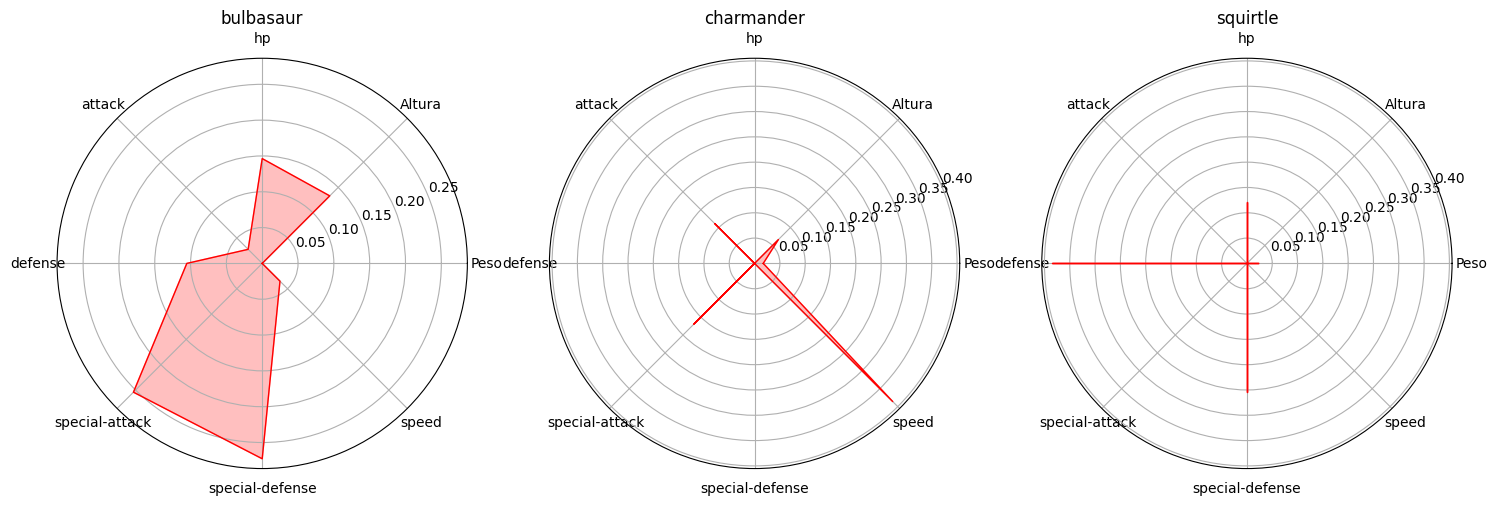

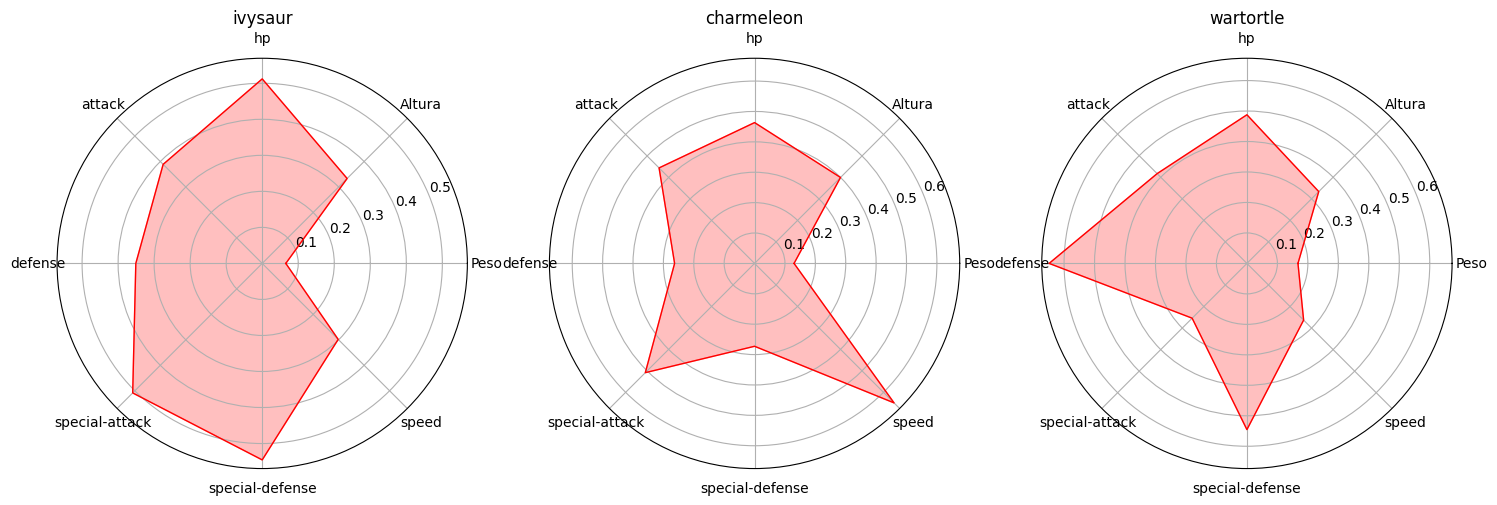

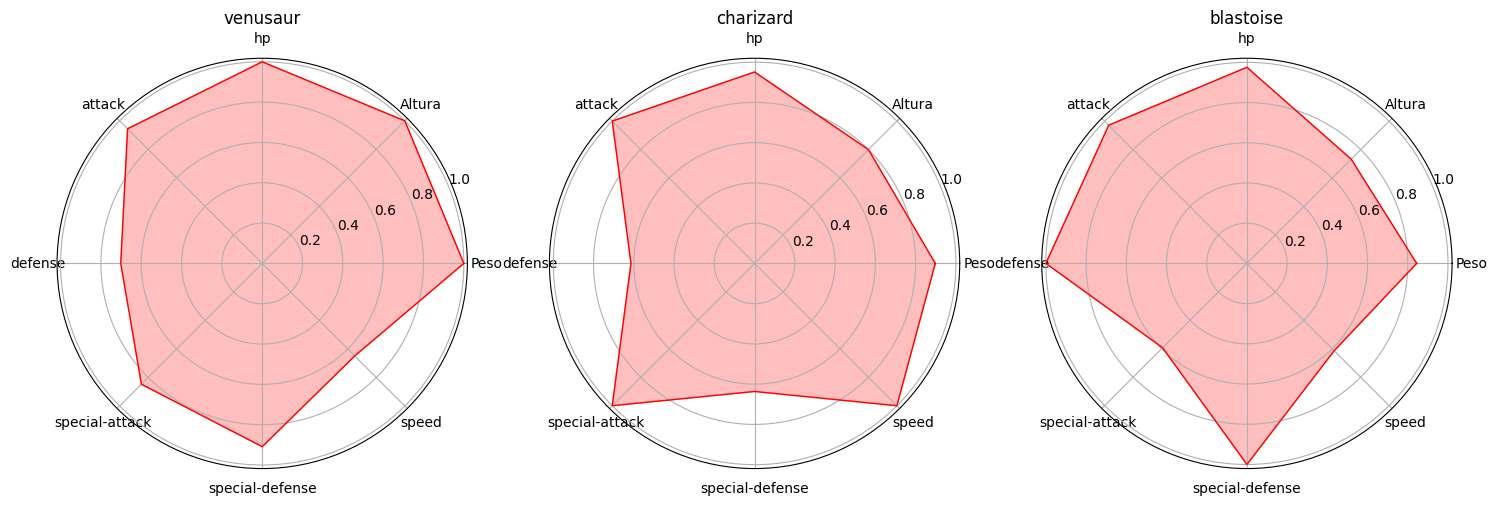

In [ ]:
for i in range(0, 3):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))
    axs = np.ravel(axs)
    if i == 0:
        indices_pokemon = [0, 3, 6]
    elif i == 1:
        indices_pokemon = [1, 4, 7]
    elif i == 2:
        indices_pokemon = [2, 5, 8]

    for j, ax in enumerate(axs):
        index = indices_pokemon[j]
        nombre_pokemon = new_pokedata.index[index]

        labels = ['Peso', 'Altura', 'hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
        values = new_pokedata.loc[nombre_pokemon].tolist()
        num_vars = len(labels)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        values += values[:1]
        angles += angles[:1]
        labels += labels[:1]

        # Grafiar los datos en las subtramas ya creadas
        ax.plot(angles, values, color='red', linewidth=1)
        ax.fill(angles, values, color='red', alpha=0.25)

        # Ajustar el rango del eje angular
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels[:-1])  # Utiliza solo las primeras 8 etiquetas

        # Poner los labels
        ax.set_title(nombre_pokemon)

plt.show()

En el caso del los graficos de radar de los pokemones iniciales, podemos ver que squirtle es el pokemon que tiene mayores atributos en defensa, asi como charmander en velocidad y bulbasaur en ataque y defensa especial. En este caso, bulbasaur es el pokemon más completo segun sus atributos.
Para el segundo grafico (primeras evoluciones), wartortle es el pokemon con más defensa pero con poco ataque en comparación a sus pares. Charmeleon es un pokemon hecho para el ataque, ya que es quien tiene más y además velocidad, sin embargo su defensa y health points (o puntos de vida) son bajos. Por el otro lado, ivysaur mejora sus ataques y defensa especiales y aumenta los otros atributos en menor medida.
Finalmente, en las ultimas evoluciones se tiene un blastoise más completo, pero aun ligado más a la defensa, se acerca bastante en puntos de vida a venusaur y en ataque a charizard, por lo que se convierte en uno de los mejores. Charizard sigue como el mejor pokemon para atacar pero con bajos puntos en defensa y defensa especial. Venasaur se acerca más a un pokemon no sobresaliente, equipara la defensa y el ataque, no es el mejor ni tampoco el peor.

# Base de datos primera generación

In [ ]:
#Creamos listas vacias
names = []
weights = []
heights = []
stats = []
ids = []

for i in range(1,152):
  url = f"https://pokeapi.co/api/v2/pokemon/{i}"

  response = requests.get(url)
  data = response.json()

  # Extraer información del Pokémon Pikachu
  name = data["name"]
  weight = data["weight"]
  height = data["height"]
  id = data['id']
  stat = {stat["stat"]["name"]: stat["base_stat"] for stat in data["stats"]}

  #Lo almacenamos en las listas vacias
  ids.append(id)
  names.append(name)
  weights.append(weight)
  heights.append(height)
  stats.append(stat)


In [ ]:
#Creamos el df con los datos guardados
pokemon_1gen = pd.DataFrame({'ID':ids, 'Nombre': names, 'Peso': weights, 'Altura': heights, 'Stats': stats})

Como ya sabemos, habrá un json anidado en la columna 'Stats' por lo que lo descomponemos

In [ ]:
# Normalizamos la columna 'Stats' para descomponer el JSON anidado en columnas separadas
normalized_stats = json_normalize(pokemon_1gen['Stats'])

# Concatenamos las columnas normalizadas al DataFrame original
pokemon_1gen = pd.concat([pokemon_1gen, normalized_stats], axis=1)

# Eliminamos la columna Stats (ya que se descompuso en 6 columnas)
pokemon_1gen = pokemon_1gen.drop(columns=['Stats'])

In [ ]:
#Vemos el nuevo df
pokemon_1gen

,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed
0,1,bulbasaur,69,7,45,49,49,65,65,45
1,2,ivysaur,130,10,60,62,63,80,80,60
2,3,venusaur,1000,20,80,82,83,100,100,80
3,4,charmander,85,6,39,52,43,60,50,65
4,5,charmeleon,190,11,58,64,58,80,65,80
...,...,...,...,...,...,...,...,...,...,...
146,147,dratini,33,18,41,64,45,50,50,50
147,148,dragonair,165,40,61,84,65,70,70,70
148,149,dragonite,2100,22,91,134,95,100,100,80
149,150,mewtwo,1220,20,106,110,90,154,90,130


In [ ]:
pokemon_1gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               151 non-null    int64 
 1   Nombre           151 non-null    object
 2   Peso             151 non-null    int64 
 3   Altura           151 non-null    int64 
 4   hp               151 non-null    int64 
 5   attack           151 non-null    int64 
 6   defense          151 non-null    int64 
 7   special-attack   151 non-null    int64 
 8   special-defense  151 non-null    int64 
 9   speed            151 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 11.9+ KB


Ahora creamos un nuevo df con el tipo de pokemon y lo unimos con **merge**

In [ ]:
#Creamos la lista vacia
types = []

# Obtener los tipos y los ID de los primeros 151 Pokémon
for i in range(1, 152):
    url = f"https://pokeapi.co/api/v2/pokemon/{i}"
    response = requests.get(url)
    data = response.json()
    pokemon_id = data['id']
    pokemon_types = [tipo['type']['name'] for tipo in data['types']]
    types.append({'ID': pokemon_id, 'Tipo(s)': pokemon_types})



In [ ]:
# Crear un DataFrame con los tipos y los ID
df_types = pd.DataFrame(types)
df_types

,ID,Tipo(s)
0,1,"[grass, poison]"
1,2,"[grass, poison]"
2,3,"[grass, poison]"
3,4,[fire]
4,5,[fire]
...,...,...
146,147,[dragon]
147,148,[dragon]
148,149,"[dragon, flying]"
149,150,[psychic]


In [ ]:
#unimos los df donde tengan coincidencia en columna 'ID' utilizando merge
df_pkm = pd.merge(pokemon_1gen, df_types, how='inner', on='ID')

In [ ]:
df_pkm

,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed,Tipo(s)
0,1,bulbasaur,69,7,45,49,49,65,65,45,"[grass, poison]"
1,2,ivysaur,130,10,60,62,63,80,80,60,"[grass, poison]"
2,3,venusaur,1000,20,80,82,83,100,100,80,"[grass, poison]"
3,4,charmander,85,6,39,52,43,60,50,65,[fire]
4,5,charmeleon,190,11,58,64,58,80,65,80,[fire]
...,...,...,...,...,...,...,...,...,...,...,...
146,147,dratini,33,18,41,64,45,50,50,50,[dragon]
147,148,dragonair,165,40,61,84,65,70,70,70,[dragon]
148,149,dragonite,2100,22,91,134,95,100,100,80,"[dragon, flying]"
149,150,mewtwo,1220,20,106,110,90,154,90,130,[psychic]


In [ ]:
#como vemos, hay pokemones con más de un tipo, por lo que separaremos estos tipos en nuevas columnas
df_pkm['Tipo 1'] = None
df_pkm['Tipo 2'] = None
df_pkm['Tipo 3'] = None

# Iteramos sobre el índice y el valor en la columna 'Tipo(s)'
for i, tipos in enumerate(df_pkm['Tipo(s)']):

  # Creamos columna cuando sea 1 solo tipo y lo asignamos a 'Tipo 1'
  if len(tipos) == 1:
    df_pkm.at[i, 'Tipo 1'] = tipos[0]

  # Verificamos si hay un segundo tipo y lo asignamos a 'Tipo 2'
  elif len(tipos) == 2:
    df_pkm.at[i, 'Tipo 1'] = tipos[0]
    df_pkm.at[i, 'Tipo 2'] = tipos[1]

  # Verificamos si hay un tercer tipo y lo asignamos a 'Tipo 3'
  elif len(tipos) == 2:
    df_pkm.at[i, 'Tipo 1'] = tipos[0]
    df_pkm.at[i, 'Tipo 2'] = tipos[1]
    df_pkm.at[i, 'Tipo 3'] = tipos[2]

In [ ]:
#Vemos como queda el df final
df_pkm

,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed,Tipo(s),Tipo 1,Tipo 2,Tipo 3
0,1,bulbasaur,69,7,45,49,49,65,65,45,"[grass, poison]",grass,poison,None
1,2,ivysaur,130,10,60,62,63,80,80,60,"[grass, poison]",grass,poison,None
2,3,venusaur,1000,20,80,82,83,100,100,80,"[grass, poison]",grass,poison,None
3,4,charmander,85,6,39,52,43,60,50,65,[fire],fire,None,None
4,5,charmeleon,190,11,58,64,58,80,65,80,[fire],fire,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,dratini,33,18,41,64,45,50,50,50,[dragon],dragon,None,None
147,148,dragonair,165,40,61,84,65,70,70,70,[dragon],dragon,None,None
148,149,dragonite,2100,22,91,134,95,100,100,80,"[dragon, flying]",dragon,flying,None
149,150,mewtwo,1220,20,106,110,90,154,90,130,[psychic],psychic,None,None


In [ ]:
df_pkm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 150
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               151 non-null    int64 
 1   Nombre           151 non-null    object
 2   Peso             151 non-null    int64 
 3   Altura           151 non-null    int64 
 4   hp               151 non-null    int64 
 5   attack           151 non-null    int64 
 6   defense          151 non-null    int64 
 7   special-attack   151 non-null    int64 
 8   special-defense  151 non-null    int64 
 9   speed            151 non-null    int64 
 10  Tipo(s)          151 non-null    object
 11  Tipo 1           151 non-null    object
 12  Tipo 2           67 non-null     object
 13  Tipo 3           0 non-null      object
dtypes: int64(9), object(5)
memory usage: 21.8+ KB


Como vemos, no existe un pokemon en el df con 3 tipos, por lo que borramos esa columna y la principal "Tipo(s)"

In [ ]:
df_pkm.drop(['Tipo(s)','Tipo 3'], axis=1,inplace=True)

In [ ]:
df_pkm


,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed,Tipo 1,Tipo 2
0,1,bulbasaur,69,7,45,49,49,65,65,45,grass,poison
1,2,ivysaur,130,10,60,62,63,80,80,60,grass,poison
2,3,venusaur,1000,20,80,82,83,100,100,80,grass,poison
3,4,charmander,85,6,39,52,43,60,50,65,fire,None
4,5,charmeleon,190,11,58,64,58,80,65,80,fire,None
...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,dratini,33,18,41,64,45,50,50,50,dragon,None
147,148,dragonair,165,40,61,84,65,70,70,70,dragon,None
148,149,dragonite,2100,22,91,134,95,100,100,80,dragon,flying
149,150,mewtwo,1220,20,106,110,90,154,90,130,psychic,None


En este caso, no es necesario tratar las filas con nulos en la columna "Tipo 2" ya que sirve como información saber que solo 67 pokemones de esta generación tienen 2 tipos y el resto es de un solo tipo.

## Gráfico de cantidades de pokemones con al menos 1 tipo

In [ ]:
#Primero agrupoamos por la cantidad de pokemones que tienen al menos un tipo
cant_pkm_1 = df_pkm.groupby('Tipo 1').size().reset_index(name='Cantidad de pokemones')
cant_pkm_1

,Tipo 1,Cantidad de pokemones
0,bug,12
1,dragon,3
2,electric,9
3,fairy,2
4,fighting,7
5,fire,12
6,ghost,3
7,grass,12
8,ground,8
9,ice,2


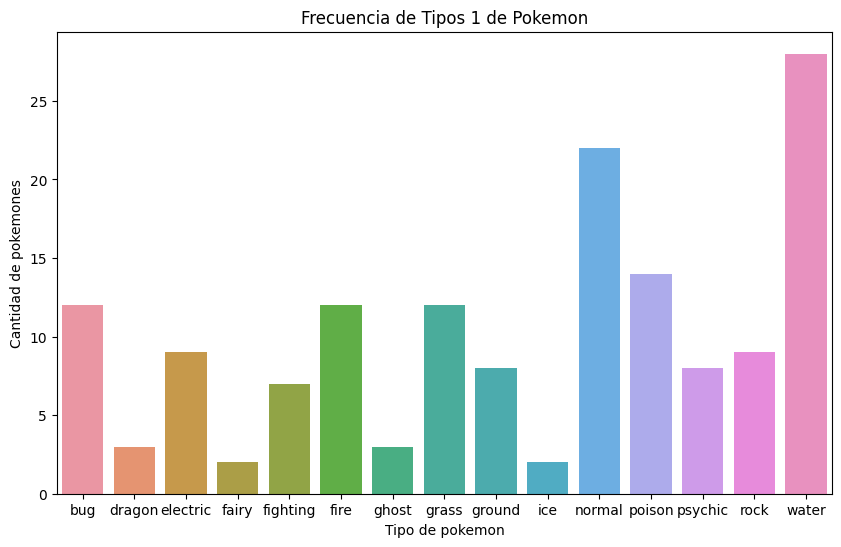

In [ ]:
#viendolo graficamente
plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo 1', y='Cantidad de pokemones', data=cant_pkm_1)
plt.xlabel('Tipo de pokemon')
plt.ylabel('Cantidad de pokemones')
plt.title('Frecuencia de Tipos 1 de Pokemon')
plt.show()

Segun lo que se puede ver, los tipos de pokemones más comunes, independiente si este tiene 1 o 2 tipos, son los de agua (28 de los 151 pokemones son al menos de tipo agua), este dato hace sentido ya que los mapas tienen tanto tierra(hierba) como agua (oceano) y todos los pokemones que aparecen en el oceano son de al menos tipo agua, no asi los que salen en tierra firme, pudiendo ser de tipo normal (en su mayoria), tipo hierba, fuego, electricidad, bicho, etc.

## Gráfico de cantidades de pokemones con 2 tipos

In [ ]:
#realizamos el mismo procedimiento, agrupoamos por la cantidad de pokemones que tienen 2 tipos
cant_pkm_2 = df_pkm.groupby('Tipo 2').size().reset_index(name='Cantidad de pokemones')
cant_pkm_2

,Tipo 2,Cantidad de pokemones
0,fairy,3
1,fighting,1
2,flying,19
3,grass,2
4,ground,6
5,ice,3
6,poison,19
7,psychic,6
8,rock,2
9,steel,2


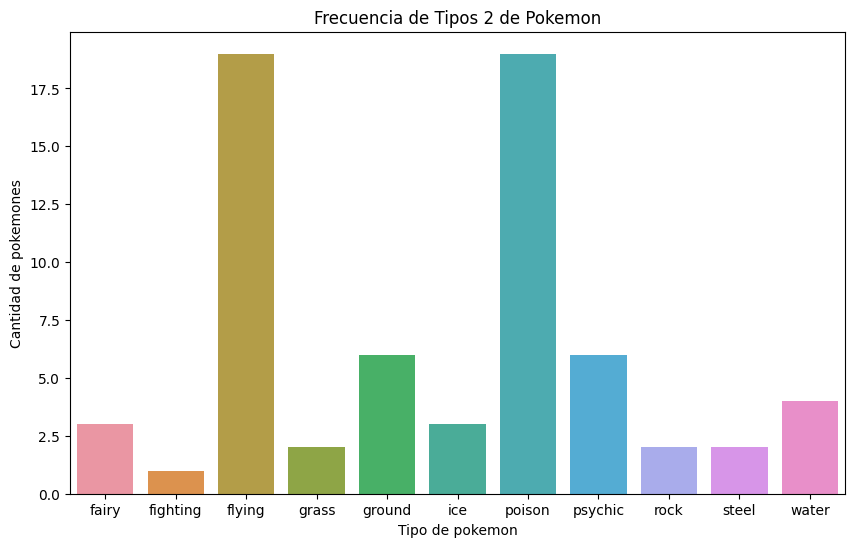

In [ ]:
#viendolo graficamente
plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo 2', y='Cantidad de pokemones', data=cant_pkm_2)
plt.xlabel('Tipo de pokemon')
plt.ylabel('Cantidad de pokemones')
plt.title('Frecuencia de Tipos 2 de Pokemon')
plt.show()

Este gráfico es interesante ya que indica que el segundo tipo más comun es el tipo vuelo y veneno (19 cada uno). Además no existe el tipo vuelo como principal, por lo que solo hay 19 pokemones de esta caracteristica en la primera generación.

## Gráfico de cantidades de pokemones de un solo tipo

In [ ]:
#como queremos solamente aquellos pokemones con un tipo y no 2, filtramos y creamos un nuevo df usando notna e isna
df_pkm_3 = df_pkm[df_pkm['Tipo 1'].notna() & df_pkm['Tipo 2'].isna()]
df_pkm_3

,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed,Tipo 1,Tipo 2
3,4,charmander,85,6,39,52,43,60,50,65,fire,None
4,5,charmeleon,190,11,58,64,58,80,65,80,fire,None
6,7,squirtle,90,5,44,48,65,50,64,43,water,None
7,8,wartortle,225,10,59,63,80,65,80,58,water,None
8,9,blastoise,855,16,79,83,100,85,105,78,water,None
...,...,...,...,...,...,...,...,...,...,...,...,...
142,143,snorlax,4600,21,160,110,65,65,110,30,normal,None
146,147,dratini,33,18,41,64,45,50,50,50,dragon,None
147,148,dragonair,165,40,61,84,65,70,70,70,dragon,None
149,150,mewtwo,1220,20,106,110,90,154,90,130,psychic,None


In [ ]:
#Como solo seleccionamos aquellos pokemones con solo tipo 1, borramos la columna Tipo 2 y reiniciamos el indice
df_pkm_3 = df_pkm_3.drop('Tipo 2', axis=1)
df_pkm_3.reset_index(inplace = True)
df_pkm_3

,index,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed,Tipo 1
0,3,4,charmander,85,6,39,52,43,60,50,65,fire
1,4,5,charmeleon,190,11,58,64,58,80,65,80,fire
2,6,7,squirtle,90,5,44,48,65,50,64,43,water
3,7,8,wartortle,225,10,59,63,80,65,80,58,water
4,8,9,blastoise,855,16,79,83,100,85,105,78,water
...,...,...,...,...,...,...,...,...,...,...,...,...
79,142,143,snorlax,4600,21,160,110,65,65,110,30,normal
80,146,147,dratini,33,18,41,64,45,50,50,50,dragon
81,147,148,dragonair,165,40,61,84,65,70,70,70,dragon
82,149,150,mewtwo,1220,20,106,110,90,154,90,130,psychic


In [ ]:
filas_grass = df_pkm.loc[df_pkm['Tipo 2'] == 'flying']

In [ ]:
filas_grass

,ID,Nombre,Peso,Altura,hp,attack,defense,special-attack,special-defense,speed,Tipo 1,Tipo 2
5,6,charizard,905,17,78,84,78,109,85,100,fire,flying
11,12,butterfree,320,11,60,45,50,90,80,70,bug,flying
15,16,pidgey,18,3,40,45,40,35,35,56,normal,flying
16,17,pidgeotto,300,11,63,60,55,50,50,71,normal,flying
17,18,pidgeot,395,15,83,80,75,70,70,101,normal,flying
20,21,spearow,20,3,40,60,30,31,31,70,normal,flying
21,22,fearow,380,12,65,90,65,61,61,100,normal,flying
40,41,zubat,75,8,40,45,35,30,40,55,poison,flying
41,42,golbat,550,16,75,80,70,65,75,90,poison,flying
82,83,farfetchd,150,8,52,90,55,58,62,60,normal,flying


In [ ]:
#agrupamos por cantidad
cant_pkm_3 = df_pkm_3.groupby('Tipo 1').size().reset_index(name='Cantidad de pokemones')
cant_pkm_3

,Tipo 1,Cantidad de pokemones
0,bug,3
1,dragon,2
2,electric,6
3,fairy,2
4,fighting,7
5,fire,10
6,grass,1
7,ground,6
8,normal,12
9,poison,10


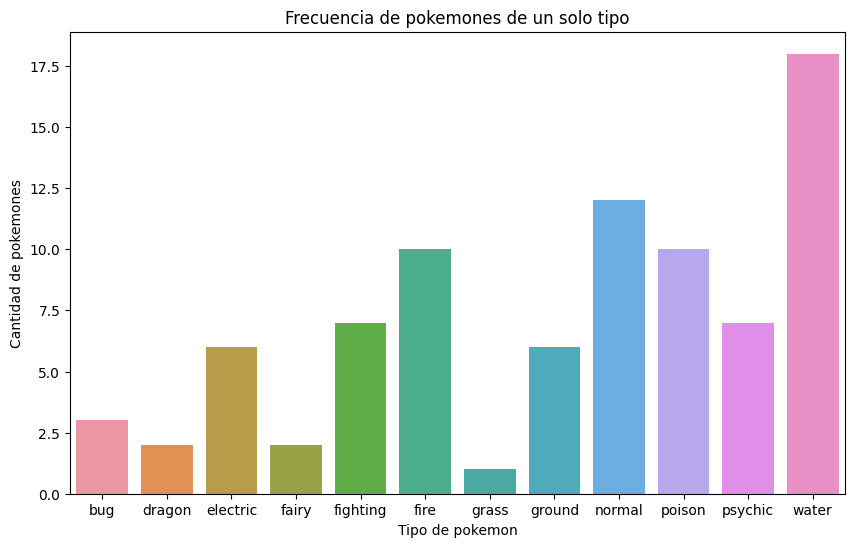

In [ ]:
#viendolo graficamente
plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo 1', y='Cantidad de pokemones', data=cant_pkm_3)
plt.xlabel('Tipo de pokemon')
plt.ylabel('Cantidad de pokemones')
plt.title('Frecuencia de pokemones de un solo tipo')
plt.show()

Tomando en cuenta solo aquellos pokemones con un solo tipo, tenemos un gráfico similar al que contabiliza los de tipo 1 pero independiente si tiene otro tipo o no. Se mantiene el tipo agua como los pokemones más frecuentes, seguido por los de tipo normal. La gran diferencia es que los pokemones que son solamente de tipo hierba son los menos frecuentes (1 pokemon entre los 151 de la primera generación), no así los que eran de tipo hierba pero tenian otro tipo más (estaban en la 4a posicion de los más frecuentes (12))